# Generating Objects w/ `Variational Auto Encoder (VAE)`

### Import dependencies

In [1]:
import os
import sys
import datetime as dt

import numpy as np
import tensorflow as tf

from dataset import ImageDataset

### Load dataset

In [2]:
data_dir = 'datasets/101_ObjectCategories/'
save_file = 'saved/data.pkl'

In [3]:
data = ImageDataset(data_dir=data_dir, size=64, grayscale=True, flatten=True)
# data.create()
# data.save(save_file=save_file, force=True)
data = data.load(save_file=save_file)

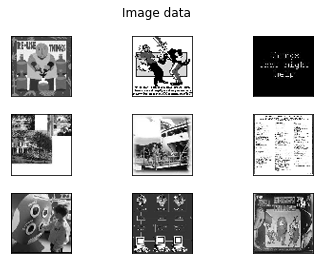

In [4]:
# visualize data
data.visualize(data.images[:9], name='Image data', smooth=True, cmap='gray')

### Hyperparameters

In [5]:
# inputs
img_size = data.size
img_channel = data.channel
img_size_flat = img_size * img_size * img_channel
num_classes = data.num_classes
print(f'Image data »»»\tsize: {img_size:,}  channels: {img_channel}  flattened: {img_size_flat:,}')
print(f'Label data »»»\tclasses: {num_classes:,}')

Image data »»»	size: 64  channels: 1  flattened: 4,096
Label data »»»	classes: 102


In [6]:
# Network
stride      = 2
kernel_size = 5
conv1_size  = 16
conv2_size  = 32
fc1_size    = 256
fc2_size    = 124
keep_prob   = 0.8

In [7]:
# Training
batch_size    = 24
learning_rate = .01
save_interval = 100
log_interval  = 1000
iterations    = 10000

## Building the network

In [8]:
def network(image, is_training=False):
    with tf.name_scope('network'):
        net = tf.reshape(image, shape=[-1, img_size, img_size, img_channel])
        net = tf.contrib.layers.conv2d(net, conv1_size, kernel_size=kernel_size, stride=stride)
        net = tf.contrib.layers.batch_norm(net, is_training=is_training)
        net = tf.contrib.layers.conv2d(net, conv2_size, kernel_size=kernel_size, stride=stride)
        net = tf.contrib.layers.batch_norm(net, is_training=is_training)
        net = tf.contrib.layers.flatten(net)
        net = tf.contrib.layers.fully_connected(net, fc1_size)
        if is_training:
            net = tf.nn.dropout(net, keep_prob=keep_prob)
        net = tf.contrib.layers.fully_connected(net, fc2_size)
        net = tf.contrib.layers.fully_connected(net, num_classes, activation_fn=None)
        return net

### Model's placeholder

In [9]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=[None, img_size_flat])
y = tf.placeholder(tf.float32, shape=[None, num_classes])

### Loss function

In [10]:
logits = network(X, is_training=True)
x_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss = tf.reduce_mean(x_entropy)

### Optimizer

In [11]:
global_step = tf.Variable(0, trainable=False, name='global_step')
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss, global_step=global_step)

### Accuracy

In [ ]:
with tf.name_scope('accuracy'):
    y_true = tf.argmax(y, axis=1)
    y_pred = tf.argmax(tf.nn.softmax(logits), axis=1)
    correct = tf.equal(y_true, y_pred)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

## Running the computation Graph

In [ ]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

### Tensorboard

In [ ]:
tensorboard_dir = 'tensorboard/'
logdir = os.path.join(tensorboard_dir, 'log')
save_path = 'models/'
save_model = os.path.join(save_path, 'model.ckpt')

tf.summary.scalar('loss', loss)
tf.summary.scalar('accuracy', accuracy)
merged = tf.summary.merge_all()

saver = tf.train.Saver()
writer = tf.summary.FileWriter(logdir=logdir, graph=sess.graph)

In [ ]:
if tf.gfile.Exists(save_path):
    try:
        last_ckpt = tf.train.latest_checkpoint(save_path)
        saver.restore(sess, save_path=last_ckpt)
        sys.stdout.write(f'INFO: Restored checkpoint from {last_ckpt}\n')
        sys.stdout.flush()
    except Exception as e:
        sys.stderr.write(f'ERR: Could not restore checkpoint. {e}\n')
        sys.stderr.flush()
else:
    tf.gfile.MakeDirs(save_path)

### Training

In [ ]:
start_time = dt.datetime.now()
for i in range(iterations):
    X_batch, y_batch = data.next_batch(batch_size=batch_size, shuffle=True)
    feed_dict = {X: X_batch, y: y_batch}
    _, _acc, _i_global = sess.run([train, accuracy, global_step], feed_dict=feed_dict)
    if i%save_interval == 0:
        saver.save(sess=sess, save_path=save_model, global_step=global_step)
        summary = sess.run(merged, feed_dict=feed_dict)
        writer.add_summary(summary=summary, global_step=_i_global)
    sys.stdout.write(f'\rIter: {i+1}\tGlobal: {_i_global}\tAcc: {_acc:.2%}'
                     f'\tTime: {dt.datetime.now() - start_time}')
    sys.stdout.flush()